In [1]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy.language import Language
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
df = pd.read_excel('../../data/raw/OMIEC_NEUROMORPHIC_07_08_24.xls')

# Carregar o modelo de linguagem SpaCy
nlp = spacy.load("en_core_web_sm")

Termos mais comuns: [('organic', 114), ('electronic', 111), ('device', 96), ('ionic', 90), ('neuromorphic', 90), ('mixed', 74), ('ion', 71), ('electrochemical', 68), ('material', 66), ('application', 56), ('conductor', 49), ('high', 47), ('polymer', 46), ('transistor', 46), ('transport', 45), ('computing', 42), ('film', 40), ('bioelectronic', 38), ('oect', 38), ('charge', 37)]


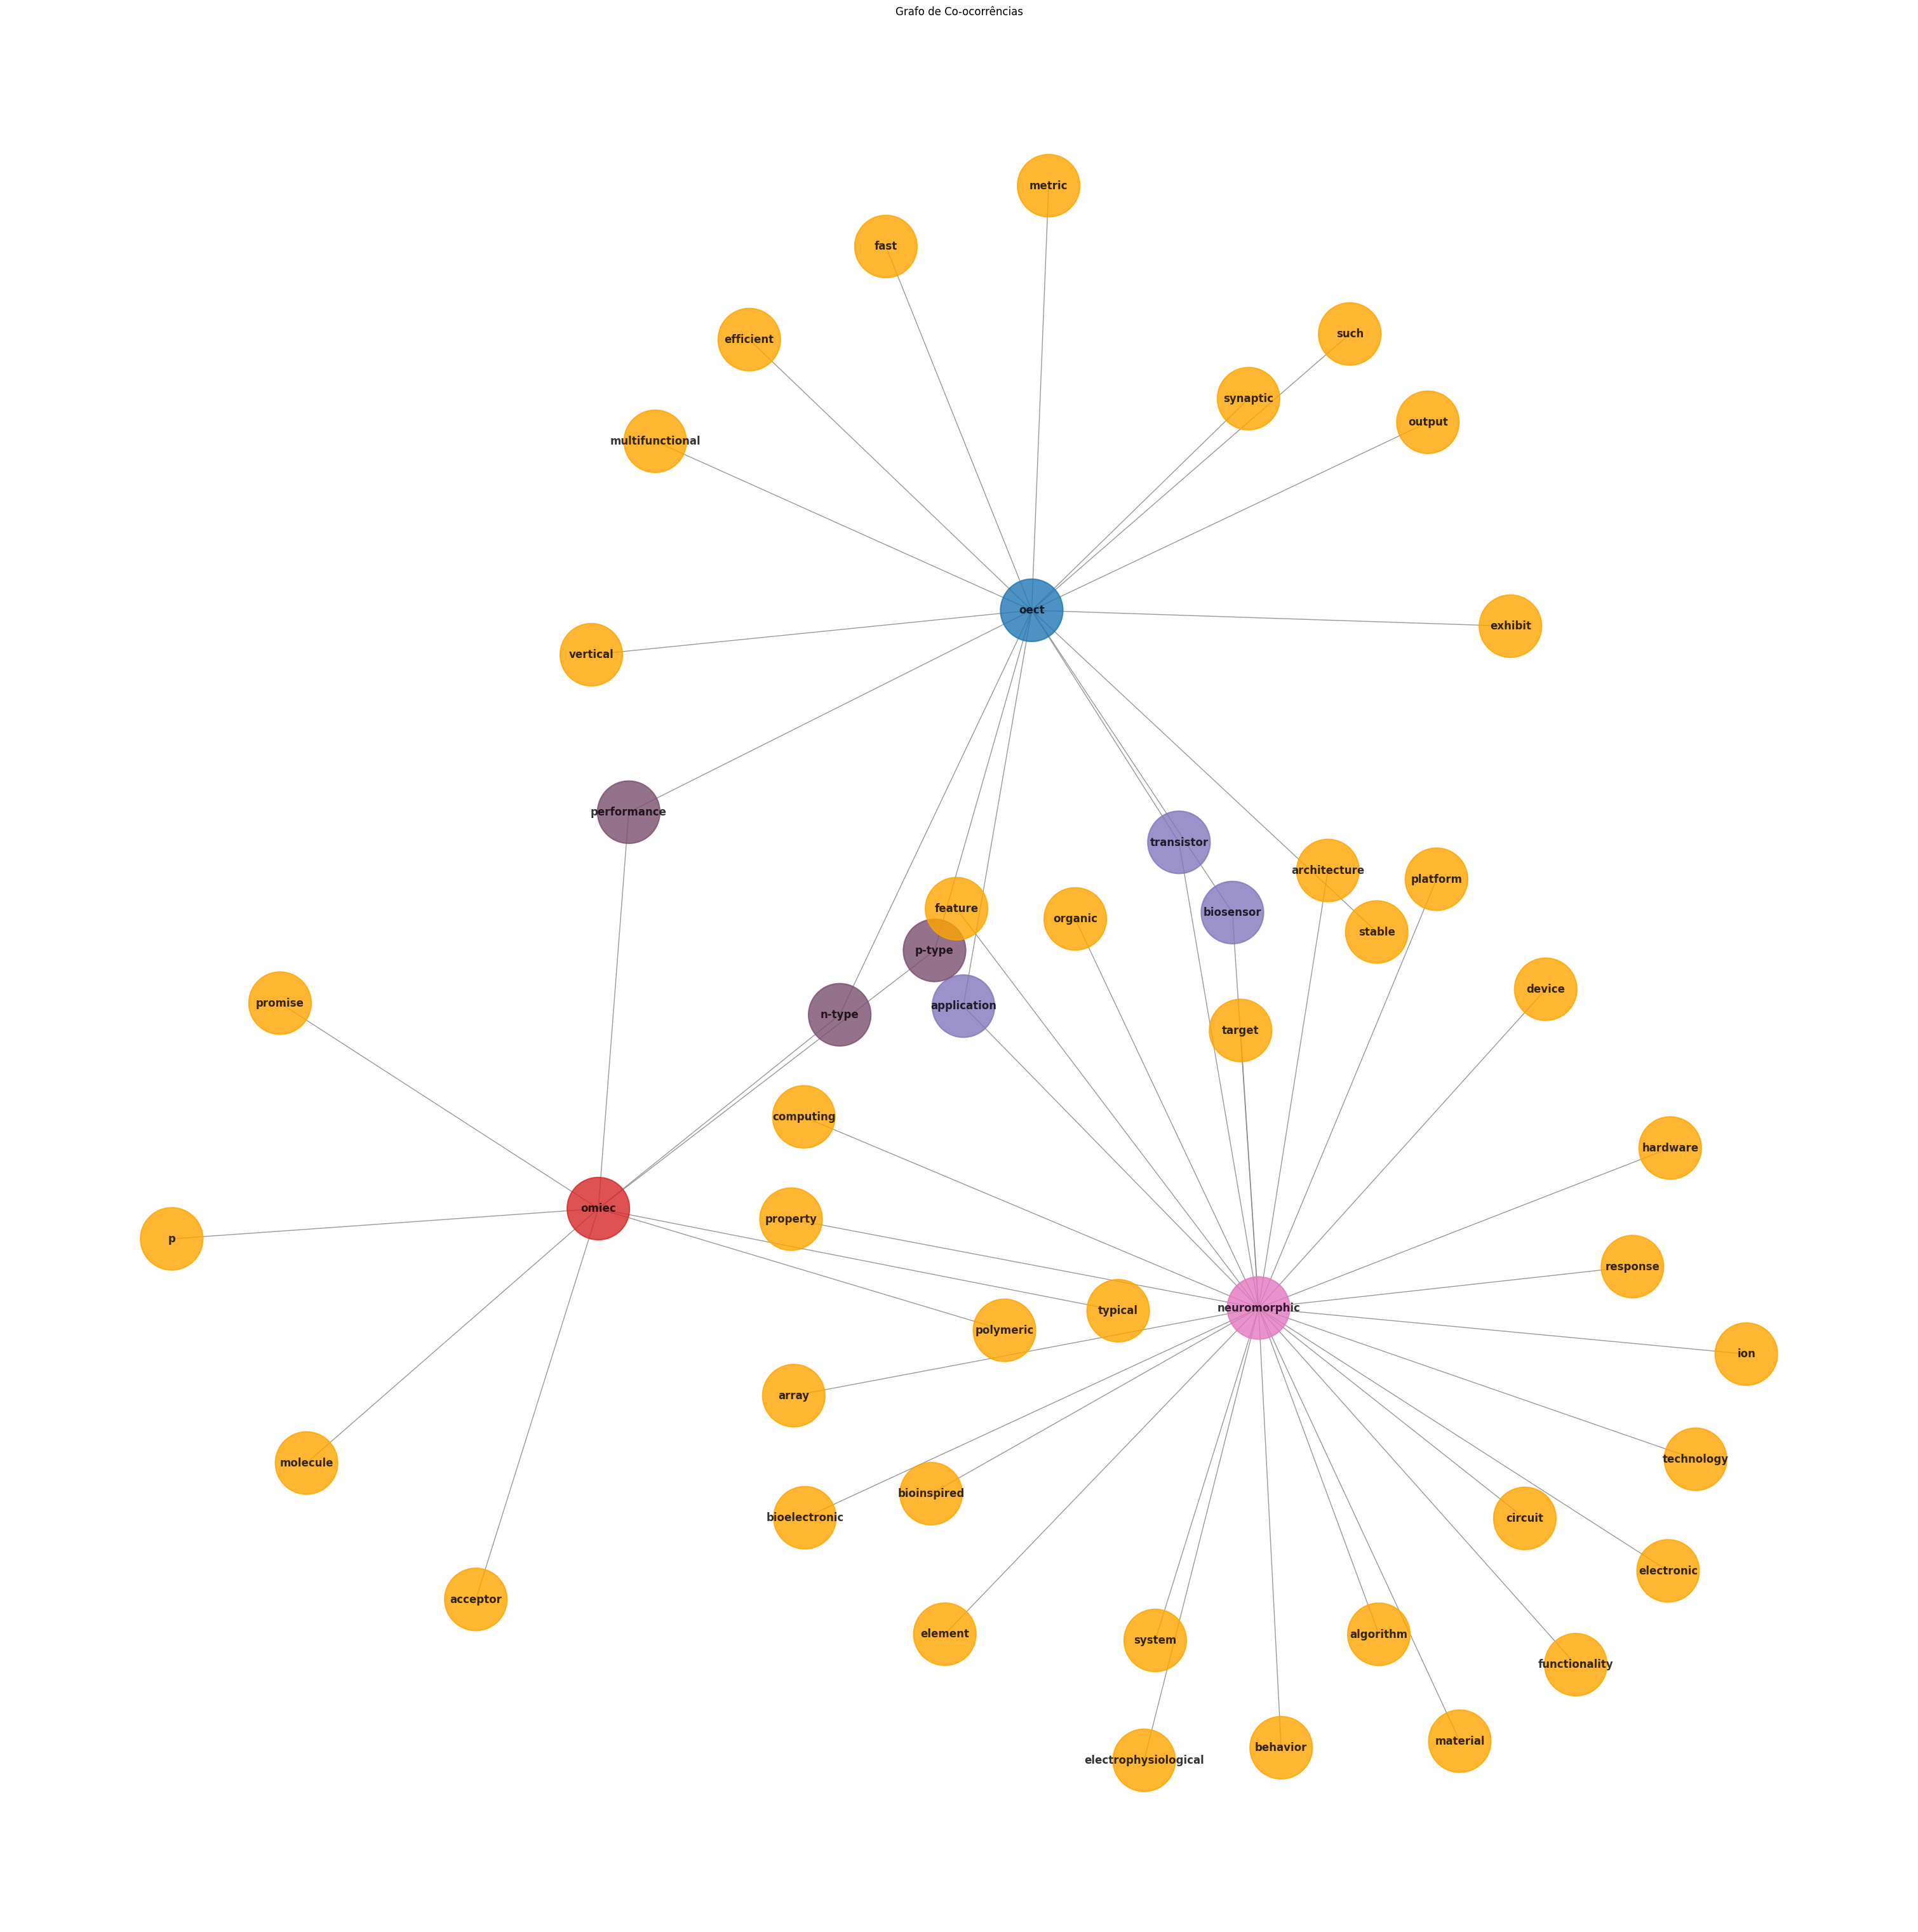

Sugestões de termos de busca: ['organic', 'electronic', 'device', 'neuromorphic', 'ion', 'material', 'application', 'transistor', 'computing', 'bioelectronic', 'oect']


In [3]:
# Criar um PhraseMatcher para identificar termos específicos como "p-type" e "n-type"
matcher = PhraseMatcher(nlp.vocab)
terms = ["p-type", "n-type"]
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("SPECIFIC_TERMS", patterns)

@Language.component("merge_phrases")
def merge_phrases(doc):
    matches = matcher(doc)
    with doc.retokenize() as retokenizer:
        for match_id, start, end in matches:
            span = Span(doc, start, end, label="COMPOUND")
            retokenizer.merge(span)
    return doc

# Adicionar o merge_phrases ao pipeline antes de qualquer outra análise
nlp.add_pipe("merge_phrases", before="ner")

# Supondo que 'df' seja um DataFrame que contém os abstracts na coluna 'Abstract'
abstracts = df['Abstract']

# Termos de interesse
focus_terms = ['oect', 'omiec', 'neuromorphic']  # Substitua com os termos de interesse
num_focus_terms = len(focus_terms)

# Atribuir cores distintas para cada termo de interesse
colormap = plt.colormaps['tab10']
colors = [colormap(i / num_focus_terms) for i in range(num_focus_terms)]  # Gerar as cores com base no número de termos
focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(focus_terms, colors)}

# Processar os abstracts com SpaCy
docs = list(nlp.pipe(abstracts))

# Análise NLP e extração de termos importantes
filtered_tokens = np.concatenate([
    [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
    for doc in docs
])

# Contar os termos filtrados
term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

# Obter os termos mais comuns
common_terms = term_freq.most_common(20)
print("Termos mais comuns:", common_terms)

# Criar um grafo de co-ocorrências
G = nx.Graph()

# Adicionar arestas ao grafo
edges = [
    (token.lemma_, child.lemma_)
    for doc in docs
    for token in doc
    if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
    for child in token.children
    if child.pos_ in ["NOUN", "ADJ"]
]

G.add_edges_from(edges)

# Verificar se focus_terms está vazio
subG = nx.Graph((term, neighbor) for term in focus_terms if term in G for neighbor in G.neighbors(term))

# Identificar nós comuns entre os termos de interesse
common_nodes = {
    node for node in subG.nodes() 
    if sum(1 for term in focus_terms if node in nx.neighbors(subG, term)) > 1
}

# Função lambda para combinar cores
blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

# Definir cores para os nós
node_colors = [
    focus_term_colors[node] if node in focus_terms else
    blend_colors([focus_term_colors[term] for term in focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
    'orange'
    for node in subG.nodes()
]

# Ajustar a visualização do subgrafo ou grafo completo
plt.figure(figsize=(10*num_focus_terms, 10*num_focus_terms))

# Usar layout para uma melhor distribuição
pos = nx.spring_layout(subG, k=0.5, iterations=50)

# Desenhar o subgrafo ou grafo completo
nx.draw(
    subG, pos, 
    with_labels=True, 
    node_size=5000, 
    node_color=node_colors, 
    font_size=12, 
    font_weight='bold',
    edge_color='gray', 
    linewidths=1.5, 
    alpha=0.8
)

plt.title("Grafo de Co-ocorrências")
plt.show()

# Sugerir termos de busca baseado nos termos mais comuns no grafo
subgraph_terms = set(subG.nodes())
search_terms = [term for term, _ in common_terms if term in subgraph_terms]
print("Sugestões de termos de busca:", search_terms)

### Playground

Termos mais comuns: [('organic', 114), ('electronic', 111), ('device', 96), ('ionic', 90), ('neuromorphic', 90), ('mixed', 74), ('ion', 71), ('electrochemical', 68), ('material', 66), ('application', 56), ('conductor', 49), ('high', 47), ('polymer', 46), ('transistor', 46), ('transport', 45), ('computing', 42), ('film', 40), ('bioelectronic', 38), ('oect', 38), ('charge', 37)]


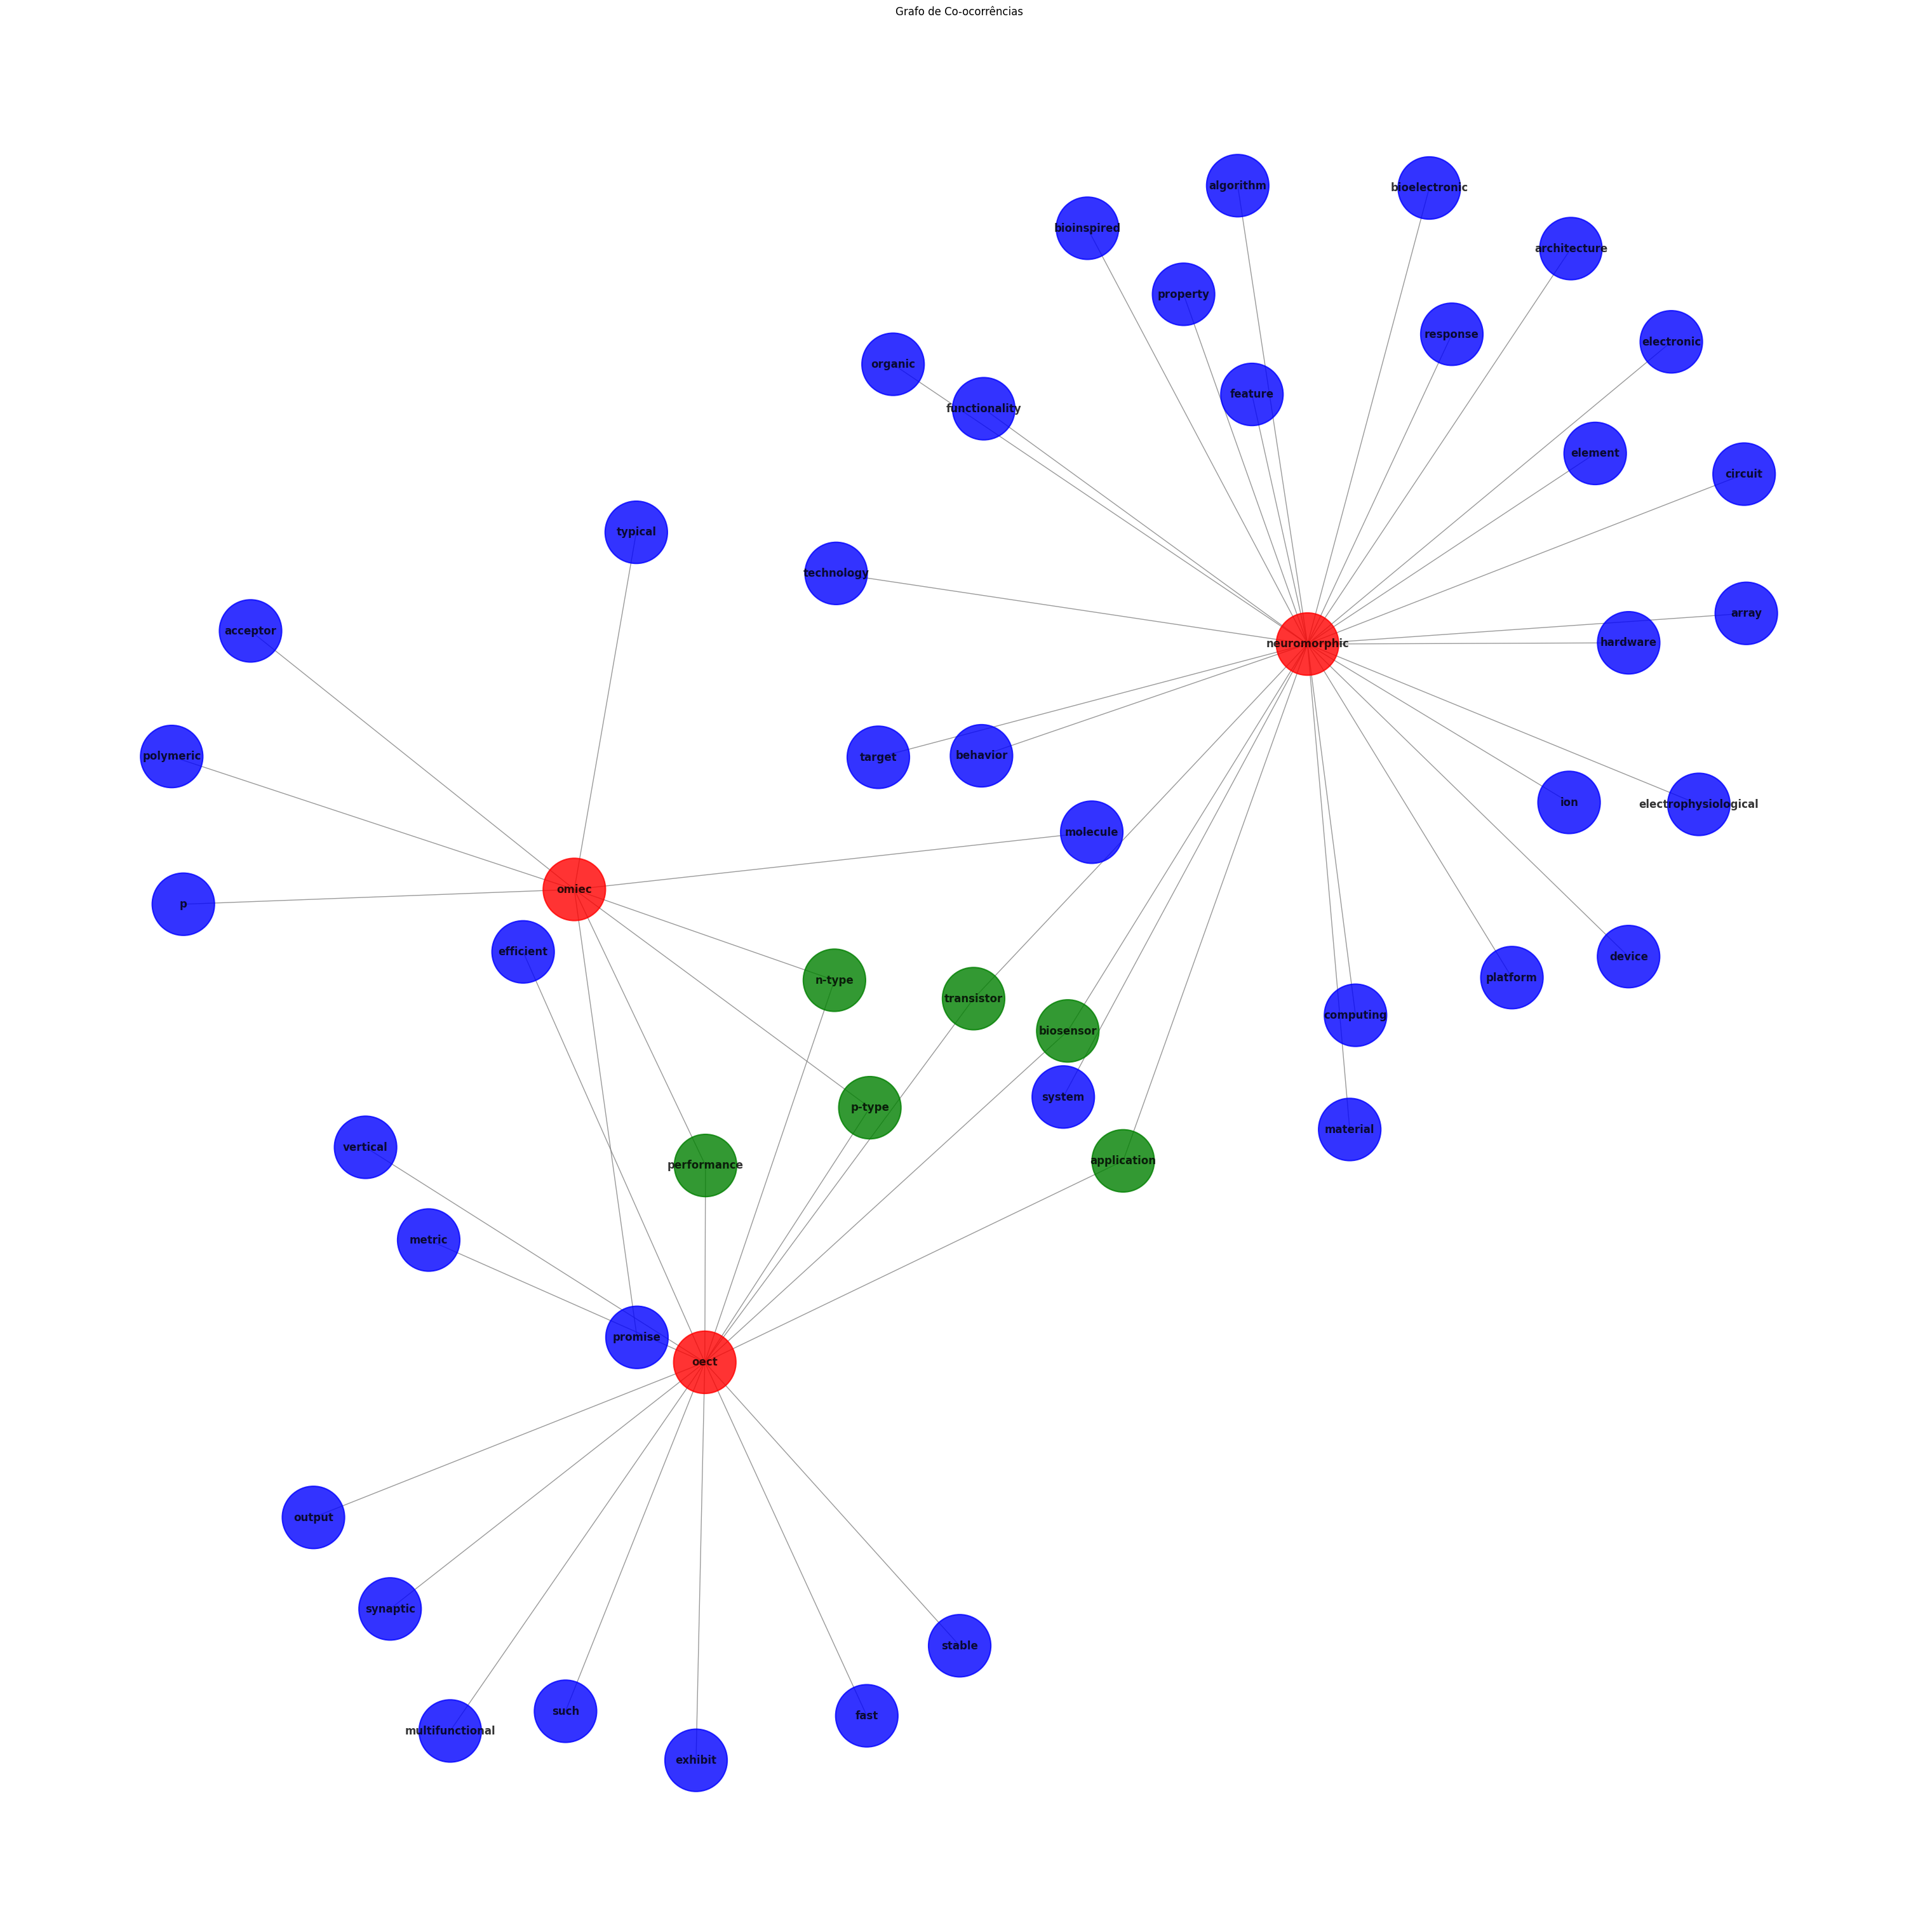

Sugestões de termos de busca: ['organic', 'electronic', 'device', 'neuromorphic', 'ion', 'material', 'application', 'transistor', 'computing', 'bioelectronic', 'oect']


In [3]:
# Carregar o modelo de linguagem SpaCy
nlp = spacy.load("en_core_web_sm")

# Criar um PhraseMatcher para identificar termos específicos como "p-type" e "n-type"
matcher = PhraseMatcher(nlp.vocab)
terms = ["p-type", "n-type"]
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("SPECIFIC_TERMS", patterns)

@Language.component("merge_phrases")
def merge_phrases(doc):
    matches = matcher(doc)
    with doc.retokenize() as retokenizer:
        for match_id, start, end in matches:
            span = Span(doc, start, end, label="COMPOUND")
            retokenizer.merge(span)
    return doc

# Adicionar o merge_phrases ao pipeline antes de qualquer outra análise
nlp.add_pipe("merge_phrases", before="ner")

# Supondo que 'df' seja um DataFrame que contém os abstracts na coluna 'Abstract'
abstracts = df['Abstract']

# Termos de interesse
focus_terms = ['oect', 'omiec', 'neuromorphic']  # Substitua com os termos de interesse
len_focus_terms = len(focus_terms)

# Processar os abstracts com SpaCy
docs = list(nlp.pipe(abstracts))

# Análise NLP e extração de termos importantes
term_freq = Counter()

# Usando numpy para fazer operações em batch
filtered_tokens = np.concatenate([
    np.array([(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct])
    for doc in docs
])

# Contar os termos filtrados
term_freq.update(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

# Obter os termos mais comuns
common_terms = term_freq.most_common(20)
print("Termos mais comuns:", common_terms)

# Criar um grafo de co-ocorrências
G = nx.Graph()

# Adicionar arestas ao grafo usando uma abordagem funcional
edges = [
    (token.lemma_, child.lemma_)
    for doc in docs
    for token in doc
    if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
    for child in token.children
    if child.pos_ in ["NOUN", "ADJ"]
]

G.add_edges_from(edges)

# Verificar se focus_terms está vazio
subG = G if not focus_terms else nx.Graph((term, neighbor) for term in focus_terms if term in G for neighbor in G.neighbors(term))

# Identificar os nós que são comuns entre os termos de interesse
common_nodes = [node for node in subG.nodes() if sum(1 for term in focus_terms if node in nx.neighbors(subG, term)) > 1]

# Definir cores para os nós
node_colors = []
for node in subG.nodes():
    if node in focus_terms:
        node_colors.append('red')  # Cor para termos de interesse
    elif node in common_nodes:
        node_colors.append('green')  # Cor para nós comuns entre termos de interesse
    else:
        node_colors.append('blue')  # Cor para outros nós

# Ajustar a visualização do subgrafo ou grafo completo
plt.figure(figsize=(10*len_focus_terms, 10*len_focus_terms))

# Usar layout para uma melhor distribuição
pos = nx.spring_layout(subG, k=0.5, iterations=50)

# Desenhar o subgrafo ou grafo completo
nx.draw(
    subG, pos, 
    with_labels=True, 
    node_size=5000, 
    node_color=node_colors, 
    font_size=12, 
    font_weight='bold',
    edge_color='gray', 
    linewidths=1.5, 
    alpha=0.8
)

plt.title("Grafo de Co-ocorrências")
plt.show()

# Sugerir termos de busca baseado nos termos mais comuns no grafo
subgraph_terms = set(subG.nodes())
search_terms = [term for term, _ in common_terms if term in subgraph_terms]
print("Sugestões de termos de busca:", search_terms)


### Playground

In [2]:
df = pd.read_excel('../../data/raw/OMIEC_NEUROMORPHIC_07_08_24.xls')

In [ ]:
# Carregar o modelo de linguagem SpaCy
nlp = spacy.load("en_core_web_sm")

# Lista de abstracts (exemplo, substitua pelos seus abstracts reais)
abstracts = df['Abstract']

# Processar os abstracts com SpaCy
docs = [nlp(abstract) for abstract in abstracts]

# Análise NLP e extração de termos importantes
term_freq = Counter()

for doc in docs:
    print(f"Texto: {doc.text}\n")
    print("Entidades Nomeadas (NER):")
    for ent in doc.ents:
        print(f"{ent.text} ({ent.label_})")
    
    print("\nTermos Importantes:")
    for token in doc:
        if token.is_stop != True and token.is_punct != True:
            print(f"{token.text} ({token.pos_})")
            if token.pos_ in ["NOUN", "ADJ"]:
                term_freq[token.lemma_] += 1
    
    print("\nDependências:")
    for token in doc:
        print(f"{token.text} --> {token.dep_} --> {token.head.text}")
    print("\n"+"-"*40+"\n")

# Termos mais comuns
common_terms = term_freq.most_common(20)
print("Termos mais comuns:", common_terms)

# Criar um grafo de co-ocorrências
G = nx.Graph()

for doc in docs:
    for token in doc:
        if token.is_stop != True and token.is_punct != True and token.pos_ in ["NOUN", "ADJ"]:
            for child in token.children:
                if child.pos_ in ["NOUN", "ADJ"]:
                    G.add_edge(token.lemma_, child.lemma_)

# Plotar o grafo de co-ocorrências
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Grafo de Co-ocorrências de Termos")
plt.show()

# Sugerir termos de busca baseado nos termos mais comuns
search_terms = [term for term, freq in common_terms]
print("Sugestões de termos de busca:", search_terms)


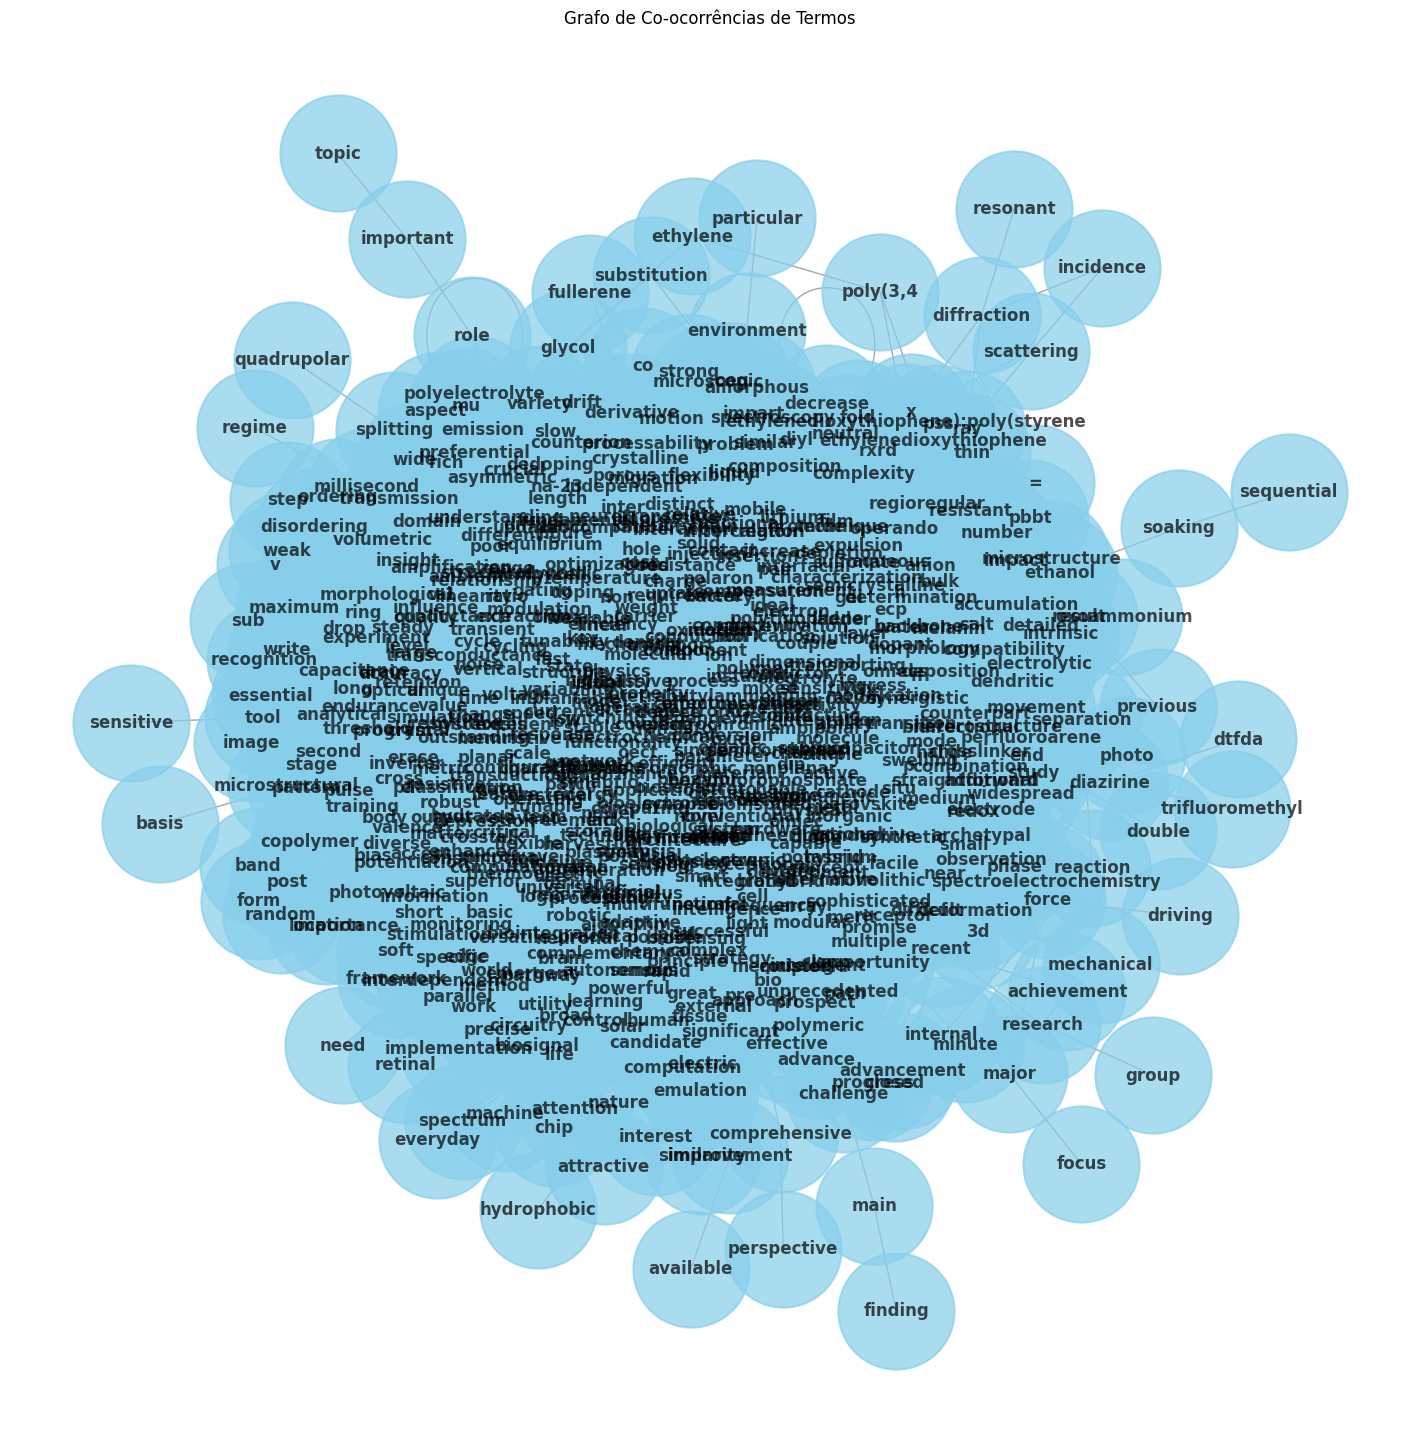

Sugestões de termos de busca: ['organic', 'electronic', 'device', 'ionic', 'neuromorphic', 'mixed', 'ion', 'electrochemical', 'material', 'application', 'conductor', 'high', 'polymer', 'transistor', 'transport', 'computing', 'film', 'bioelectronic', 'oect', 'charge']


In [3]:
import spacy
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Carregar o modelo de linguagem SpaCy
nlp = spacy.load("en_core_web_sm")

# Lista de abstracts (exemplo, substitua pelos seus abstracts reais)
abstracts = df['Abstract']

# Processar os abstracts com SpaCy
docs = [nlp(abstract) for abstract in abstracts]

# Análise NLP e extração de termos importantes
term_freq = Counter()

for doc in docs:
    for token in doc:
        if token.is_stop != True and token.is_punct != True:
            if token.pos_ in ["NOUN", "ADJ"]:
                term_freq[token.lemma_] += 1

# Filtrar para mostrar apenas os termos mais comuns
common_terms = term_freq.most_common(20)

# Criar um grafo de co-ocorrências
G = nx.Graph()

for doc in docs:
    for token in doc:
        if token.is_stop != True and token.is_punct != True and token.pos_ in ["NOUN", "ADJ"]:
            for child in token.children:
                if child.pos_ in ["NOUN", "ADJ"]:
                    # Adicionar aresta ao grafo se ambos os termos forem comuns
                    if term_freq[token.lemma_] > 1 and term_freq[child.lemma_] > 1:
                        G.add_edge(token.lemma_, child.lemma_)

# Ajustar a visualização do grafo
plt.figure(figsize=(14, 14))

# Usar um layout diferente para distribuir melhor os nós
pos = nx.kamada_kawai_layout(G)

# Desenhar o grafo
nx.draw(
    G, pos, 
    with_labels=True, 
    node_size=7000, 
    node_color='skyblue', 
    font_size=12, 
    font_weight='bold',
    edge_color='gray', 
    linewidths=1.5, 
    alpha=0.7
)

plt.title("Grafo de Co-ocorrências de Termos")
plt.show()

# Sugerir termos de busca baseado nos termos mais comuns
search_terms = [term for term, freq in common_terms]
print("Sugestões de termos de busca:", search_terms)


#### Playground

In [ ]:
import spacy
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Carregar o modelo de linguagem SpaCy
nlp = spacy.load("en_core_web_sm")

# Lista de abstracts (exemplo, substitua pelos seus abstracts reais)
abstracts = [
    "Abstract 1 text on OMIECs and neuromorphic devices...",
    "Abstract 2 discussing the applications of OMIECs in neuromorphic computing...",
    "Further exploration of polymer-based OMIECs in the context of neuromorphic technology...",
    # Adicione mais abstracts aqui
]

# Termos de interesse
focus_terms = {"organic", "ionic", "electronic", "omiec", "conductor", "mixed"}

# Processar os abstracts com SpaCy
docs = [nlp(abstract) for abstract in abstracts]

# Análise NLP e extração de termos importantes
term_freq = Counter()

for doc in docs:
    for token in doc:
        if token.is_stop != True and token.is_punct != True:
            if token.pos_ in ["NOUN", "ADJ"]:
                term_freq[token.lemma_] += 1

# Criar um grafo de co-ocorrências
G = nx.Graph()

for doc in docs:
    for token in doc:
        if token.is_stop != True and token.is_punct != True and token.pos_ in ["NOUN", "ADJ"]:
            for child in token.children:
                if child.pos_ in ["NOUN", "ADJ"]:
                    G.add_edge(token.lemma_, child.lemma_)

# Criar um subgrafo focado nos termos de interesse
subG = nx.Graph()

for term in focus_terms:
    if term in G:
        neighbors = G.neighbors(term)
        subG.add_node(term)
        for neighbor in neighbors:
            subG.add_edge(term, neighbor)

# Ajustar a visualização do subgrafo
plt.figure(figsize=(10, 10))

# Usar layout para uma melhor distribuição
pos = nx.spring_layout(subG, k=0.5, iterations=50)

# Desenhar o subgrafo
nx.draw(
    subG, pos, 
    with_labels=True, 
    node_size=5000, 
    node_color='lightgreen', 
    font_size=12, 
    font_weight='bold',
    edge_color='black', 
    linewidths=1.5, 
    alpha=0.8
)

plt.title("Subgrafo de Co-ocorrências dos Termos Focados")
plt.show()

# Sugerir termos de busca baseado nos termos mais comuns no subgrafo
subgraph_terms = set(subG.nodes())
search_terms = [term for term, freq in common_terms if term in subgraph_terms]
print("Sugestões de termos de busca:", search_terms)